In [1]:
import os
import requests
import zipfile

# Get the current working directory
current_directory = os.getcwd()

# Set the path for the 'data' directory
data_directory = os.path.join(current_directory, 'data')
os.makedirs(data_directory, exist_ok=True)

# URL and file paths
url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
filename = "ml-latest-small.zip"
unzipped_folder_name = filename.replace('.zip', '')
path_zip = os.path.join(data_directory, filename)
path_unzipped = os.path.join(data_directory, unzipped_folder_name)

# Check if the unzipped folder already exists
if not os.path.exists(path_unzipped):
    print(f"Folder {unzipped_folder_name} not found. Downloading and unzipping...")

    # Download the zip file
    response = requests.get(url)
    with open(path_zip, 'wb') as file:
        file.write(response.content)
    print("Download completed.")

    # Unzip the file
    with zipfile.ZipFile(path_zip, 'r') as zip_ref:
        zip_ref.extractall(data_directory)
    print("Unzipping completed.")

    # Delete the zip file
    os.remove(path_zip)
    print("Zip file deleted.")
else:
    print(f"Folder {unzipped_folder_name} already exists.")


Folder ml-latest-small already exists.


In [2]:
import pandas as pd

ratings_filename = "ratings.csv"
path_ratings = os.path.join(path_unzipped, ratings_filename)
ratings = pd.read_csv(path_ratings)
ratings.tail(5)


,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [3]:
from scipy.sparse import coo_matrix

sparse_matrix = coo_matrix((ratings['rating'], (ratings['movieId'], ratings['userId'])))

# csr for slicing capabilities
sparse_matrix_csr = sparse_matrix.tocsr()
rows_with_ratings = sparse_matrix_csr.sum(axis=1).A1 != 0
ratings_matrix = sparse_matrix_csr[rows_with_ratings]

print(ratings_matrix.shape)

(9724, 611)


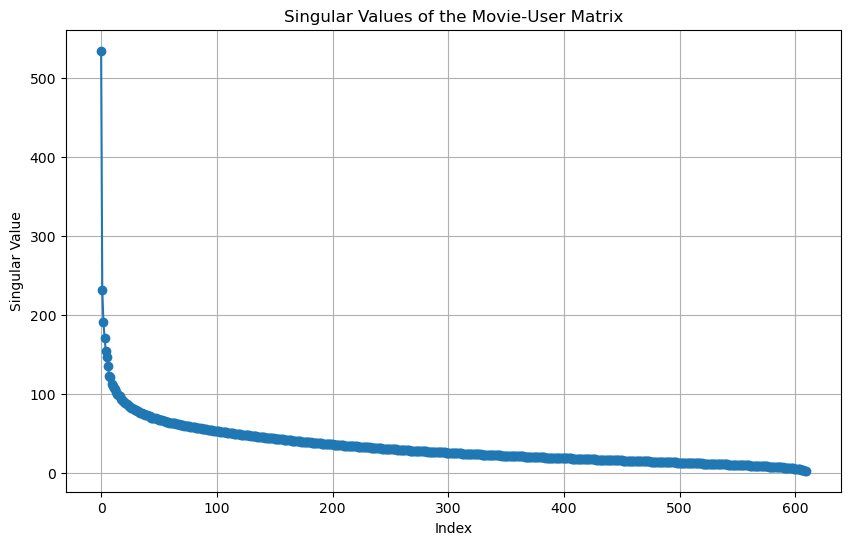

In [4]:
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

# k, number of singular values, so minimum of the shape
k = min(ratings_matrix.shape) - 1 
u, s, vt = svds(ratings_matrix, k=k)

# Values in descending order, order of importance 
singular_values = sorted(s, reverse=True)

# Plot the singular values
plt.figure(figsize=(10, 6))
plt.plot(singular_values, 'o-')
plt.title("Singular Values of the Movie-User Matrix")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.grid()
plt.show()


In [5]:
import numpy as np

differences = -np.diff(singular_values)

# Criterion for a significant gap
significance = .01

threshold = significance * differences[0]
significant_rank = np.argmax(differences < threshold) + 1

print(f"The significant rank is: {significant_rank}. \nThis rank is determined as the point where the gap between "
      f"consecutive singular values is less than {significance * 100:.2f}% of the first gap.")

The significant rank is: 8. 
This rank is determined as the point where the gap between consecutive singular values is less than 1.00% of the first gap.


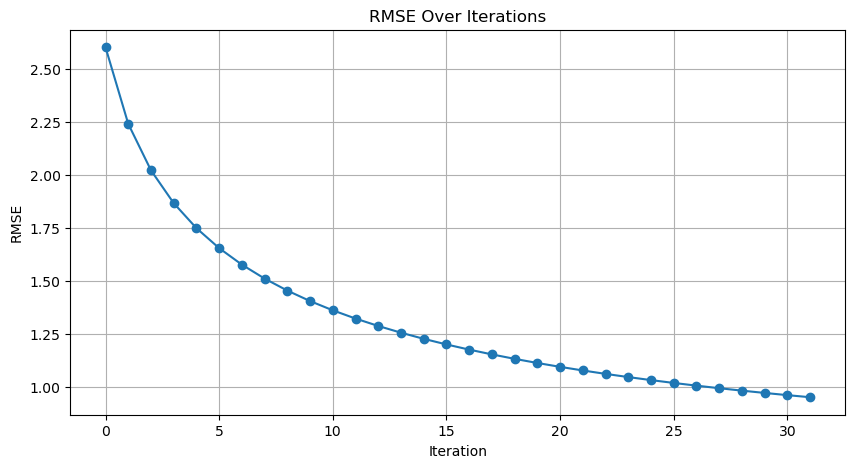

Final RMSE: 0.9592687270692261
Best RMSE obtained: 0.9493763406964919


In [6]:
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from scipy.sparse import find

# RMSE function
def rmse(y_true, y_pred, rows, cols):
    y_pred_values = y_pred[rows, cols]
    diff = y_true - y_pred_values
    return np.sqrt(np.mean(diff ** 2))

# Get known entries indices and values
rows, cols, ratings = find(ratings_matrix)

# Initialize variables
X_n = np.zeros(ratings_matrix.shape)
threshold = 0.01  # Stopping criterion threshold
r = significant_rank  # Rank obtained from previous calculations
rmse_previous = float('inf')
convergence = False
rmse_values = []  # List to store RMSE values for plotting

# SVP algorithm loop
while not convergence:
    # Compute the current ratings for the known entries
    current_ratings = X_n[rows, cols]

    # Update the known entries with the residuals
    X_n[rows, cols] += ratings - current_ratings

    # Perform hard thresholded SVD on the updated estimate
    U, sigma, Vt = svds(X_n, k=r)
    
    # Reconstruct the matrix
    X_n = U @ np.diag(sigma) @ Vt
    
    # Calculate RMSE for known entries
    rmse_current = rmse(ratings, X_n, rows, cols)
    rmse_values.append(rmse_current)  # Store RMSE for plotting

    # Check stopping criteria
    if rmse_current > rmse_previous - threshold:
        convergence = True
    else:
        rmse_previous = rmse_current# Calculate RMSE for known entries

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, marker='o')
plt.title('RMSE Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Output the final RMSE and the best RMSE obtained
print(f"Final RMSE: {rmse_previous}")
print(f"Best RMSE obtained: {min(rmse_values)}")


Iteration RMSE: 2.8886652417438246
Iteration RMSE: 2.6468003999450938
Iteration RMSE: 2.5069139522067
Iteration RMSE: 2.4139070383597674
Iteration RMSE: 2.3459502392351075
Iteration RMSE: 2.2954902763605007
Iteration RMSE: 2.2557183962168534
Iteration RMSE: 2.220327639860731
Iteration RMSE: 2.1895305132135197
Iteration RMSE: 2.164466355152234
Iteration RMSE: 2.1437118470476544
Iteration RMSE: 2.126247861942439
Iteration RMSE: 2.111327154354441
Iteration RMSE: 2.0969877416706533
Iteration RMSE: 2.082383406238613
Iteration RMSE: 2.069752468807178
Iteration RMSE: 2.05872515864617
Iteration RMSE: 2.049008233045961


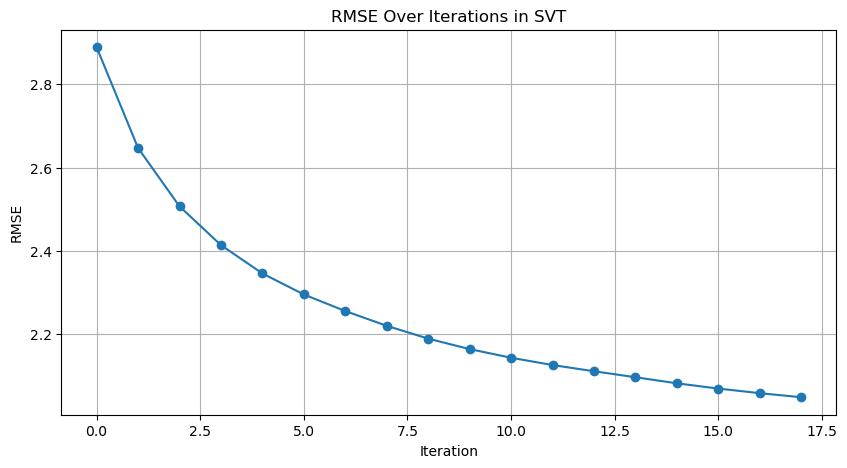

Final RMSE: 2.049008233045961


In [7]:
from numpy.linalg import svd

# Soft-thresholding operator
def soft_threshold(x, lambda_val):
    return np.sign(x) * np.maximum(np.abs(x) - lambda_val, 0)

# Get known entries indices and values
rows, cols, ratings = find(ratings_matrix)

# Initialize variables
X_n = np.zeros(ratings_matrix.shape)
lambda_val = 100  # Lambda value needs to be chosen appropriately
step_size = 1.0  # Step size for the gradient step
rmse_values = []  # List to store RMSE values for plotting
convergence = False
threshold = 0.01  # Stopping criterion threshold
rmse_previous = float('inf')

# SVT algorithm loop
while not convergence:
    # Compute the current ratings for the known entries
    current_ratings = X_n[rows, cols]

    # Update the known entries with the residuals
    X_n[rows, cols] += step_size * (ratings - current_ratings)

    # Perform full SVD on the updated estimate
    U, sigma, Vt = svd(X_n, full_matrices=False)
    
    # Apply soft-thresholding to the singular values
    sigma_thresholded = soft_threshold(sigma, lambda_val)
    
    # Reconstruct the matrix
    X_n = U @ np.diag(sigma_thresholded) @ Vt
    
    # Calculate RMSE for known entries
    rmse_current = rmse(ratings, X_n, rows, cols)
    rmse_values.append(rmse_current)  # Store RMSE for plotting

    # Check stopping criteria
    if len(rmse_values) > 1 and (rmse_previous - rmse_current < threshold or rmse_previous <= rmse_current):
        convergence = True
    
    rmse_previous = rmse_current
    print(f'Iteration RMSE: {rmse_current}')

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, marker='o')
plt.title('RMSE Over Iterations in SVT')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Output the final RMSE
print(f"Final RMSE: {rmse_current}")


Iteration 1, RMSE: 2.3566393776284142, Relative Error: 0.6450434538633832
Iteration 2, RMSE: 1.8697476033440041, Relative Error: 0.511774717575804
Iteration 3, RMSE: 1.6384670371954868, Relative Error: 0.4484701591371468
Iteration 4, RMSE: 1.474537492028512, Relative Error: 0.4036004684205418
Iteration 5, RMSE: 1.3696642437962432, Relative Error: 0.37489526944109886
Iteration 6, RMSE: 1.2891981721844323, Relative Error: 0.3528706384160778
Iteration 7, RMSE: 1.2360599033701154, Relative Error: 0.33832598946652076
Iteration 8, RMSE: 1.1957869924734479, Relative Error: 0.3273027596128038
Iteration 9, RMSE: 1.166669241231473, Relative Error: 0.3193328449079246


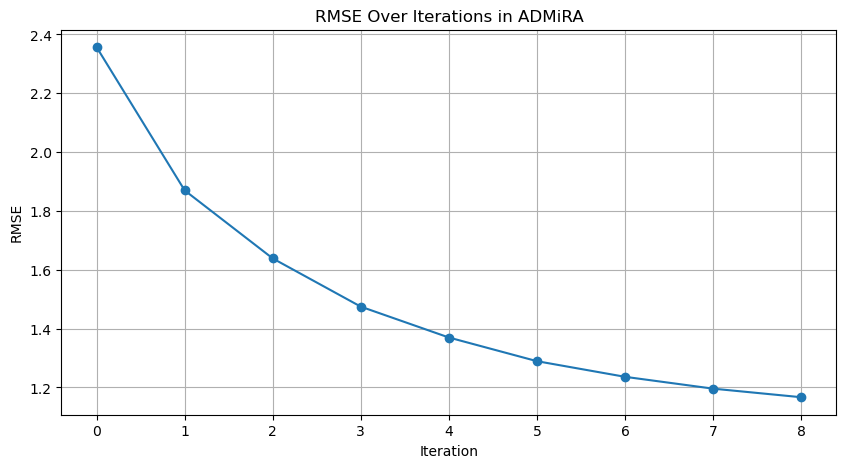

Best RMSE obtained: 1.166669241231473


In [10]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix, csr_matrix

# Define rows, cols, and ratings
rows, cols = ratings_matrix.nonzero()
ratings = ratings_matrix.data

# Calculate the norm of the observations
norm_y = np.linalg.norm(ratings)

# Initialize variables
X_hat = np.zeros((ratings_matrix.shape[0], ratings_matrix.shape[1]))
Psi_full = []
Psi_known = np.empty((len(ratings), 0))
rmse_values = []
relative_errors = []
epsilon = 0.01  # Stopping criterion threshold
r = significant_rank  # Rank obtained from previous calculations
convergence = False


# Step 3: Compute the residual for the observed entries
residuals = coo_matrix((ratings - X_hat[rows, cols], (rows, cols)), shape=ratings_matrix.shape)

# ADMIRA algorithm loop
while not convergence:
    # Step 4: Compute SVD on the residual
    U, s, Vt = svds(residuals, k=2*r)

    # Form Psi' using the singular vectors (keep as sparse matrices)
    Psi_prime_full = [coo_matrix(np.outer(U[:, k], Vt[k, :])).tocsr() for k in range(2*r)]

    # Combine full Psi and Psi_prime_full (use vstack for sparse matrices)
    Psi_full.extend(Psi_prime_full)

    # Combine Psi and Psi_prime and orthogonalize using only the known values
    Psi_known = np.vstack([psi[rows, cols] for psi in Psi_full])
    Q, R = np.linalg.qr(Psi_known.T)

    # Solve the least squares problem
    coefficients, _, _, _ = np.linalg.lstsq(Psi_known.T, ratings, rcond=None)
    
    # X_e is initially a zero matrix of the appropriate shape
    X_e = csr_matrix(ratings_matrix.shape)

    # Iterate over Psi_full and coefficients to construct X_e
    for psi, coeff in zip(Psi_full, coefficients):
        # Multiply each basis matrix by its corresponding coefficient and add to X_e
        X_e += psi.multiply(coeff)

    # Update Psi
    U, s, Vt = svds(X_e, k=r)  # Perform SVD on X_e
    Psi_full = [coo_matrix(np.outer(U[:, k], Vt[k, :])).tocsr() for k in range(r)]

    # Reconstruct X_e from U, Sigma, and V^T
    Sigma = np.diag(s)
    X_hat = U @ Sigma @ Vt  # This is the matrix reconstructed from its SVD components

    # Calculate RMSE for known entries and check for convergence
    rmse_current = rmse(ratings, X_hat, rows, cols)
    rmse_values.append(rmse_current)

    residuals = coo_matrix((ratings - X_hat[rows, cols], (rows, cols)), shape=ratings_matrix.shape).toarray()
    norm_residuals = np.linalg.norm(residuals)

    # Calculate the relative error
    relative_errors.append(norm_residuals / norm_y)
    # Check stopping criteria
    if len(rmse_values) > 1 and relative_errors[-1] > relative_errors[-2] - epsilon:\
        convergence = True

    print(f'Iteration {len(rmse_values)}, RMSE: {rmse_current}, Relative Error: {relative_errors[-1]}')

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, marker='o')
plt.title('RMSE Over Iterations in ADMiRA')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# Output the best RMSE obtained
print(f"Best RMSE obtained: {min(rmse_values)}")
